In [7]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm

# ======================
# 1. Custom Multimodal Dataset
# ======================
class MultiModalDataset(Dataset):
    def __init__(self, root_dir, tokenizer, max_len, image_transform=None):
        """
        Expects a folder structure:
            root_dir/
                class1/
                    image1.jpg
                    image2.jpg
                    ...
                class2/
                    ...
        The text is extracted from the file name (by removing extension, replacing underscores, etc.)
        """
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_transform = image_transform
        self.samples = []  # each element is a tuple (image_path, text, label)
        self.class_folders = sorted(os.listdir(root_dir))
        self.label_map = {cls: idx for idx, cls in enumerate(self.class_folders)}
        
        for cls in self.class_folders:
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path):
                for file in sorted(os.listdir(cls_path)):
                    file_path = os.path.join(cls_path, file)
                    if os.path.isfile(file_path):
                        file_name_no_ext, _ = os.path.splitext(file)
                        text = file_name_no_ext.replace('_', ' ')
                        text = re.sub(r'\d+', '', text)
                        self.samples.append((file_path, text, self.label_map[cls]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, text, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.image_transform:
            image = self.image_transform(image)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'image': image,
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ======================
# 2. Multimodal Model Definition
# ======================
class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes, fusion_dim=512, text_model_name='distilbert-base-uncased', freeze_image_layers=True):
        """
        fusion_dim: common embedding dimension for both modalities.
        freeze_image_layers: if True, freeze most image model parameters except for the last two transformer blocks.
        """
        super(MultiModalClassifier, self).__init__()
        self.fusion_dim = fusion_dim
        
        # ---- Text model: DistilBERT ----
        self.text_model = DistilBertModel.from_pretrained(text_model_name)
        self.text_projection = nn.Linear(self.text_model.config.hidden_size, fusion_dim)
        self.text_dropout = nn.Dropout(0.5)
        
        # ---- Image model: Vision Transformer (ViT) ----
        self.image_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        self.image_model.heads = nn.Identity()  # Remove classification head
        
        if freeze_image_layers:
            last_block_index = len(self.image_model.encoder.layers) - 1
            second_last_index = last_block_index - 1
            for name, param in self.image_model.named_parameters():
                if 'encoder.layers' in name:
                    block_str = name.split('.')[2]
                    if block_str.startswith('encoder_layer_'):
                        block_index = int(block_str.split('_')[-1])
                    else:
                        block_index = int(block_str)
                    if block_index not in [second_last_index, last_block_index]:
                        param.requires_grad = False
                else:
                    param.requires_grad = False
        
        if 768 != fusion_dim:
            self.image_projection = nn.Linear(768, fusion_dim)
        else:
            self.image_projection = nn.Identity()
        self.image_dropout = nn.Dropout(0.5)
        
        # ---- Gating Mechanism for Fusion ----
        self.gate = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.ReLU(),
            nn.Linear(fusion_dim, fusion_dim),
            nn.Sigmoid()
        )
        self.fusion_dropout = nn.Dropout(0.5)
        
        # ---- Classification Head ----
        self.classifier = nn.Linear(fusion_dim, num_classes)
    
    def forward(self, input_ids, attention_mask, image):
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        text_feat = self.text_dropout(text_feat)
        text_feat = self.text_projection(text_feat)
        
        image_feat = self.image_model(image)
        image_feat = self.image_dropout(image_feat)
        image_feat = self.image_projection(image_feat)
        
        gate_weights = self.gate(torch.cat([text_feat, image_feat], dim=1))
        fused_feat = gate_weights * text_feat + (1 - gate_weights) * image_feat
        fused_feat = self.fusion_dropout(fused_feat)
        
        logits = self.classifier(fused_feat)
        return logits

# ======================
# 3. Data Preparation with Enhanced Augmentation
# ======================
train_image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 24

TRAIN_PATH = './CVPR_2024_dataset_Train'
VAL_PATH = './CVPR_2024_dataset_Val'
TEST_PATH = './CVPR_2024_dataset_Test'

train_dataset = MultiModalDataset(TRAIN_PATH, tokenizer, max_len, image_transform=train_image_transform)
val_dataset = MultiModalDataset(VAL_PATH, tokenizer, max_len, image_transform=val_test_transform)
test_dataset = MultiModalDataset(TEST_PATH, tokenizer, max_len, image_transform=val_test_transform)

# ======================
# Create DataLoaders with Balancing for Training Data
# ======================
train_labels = [sample[2] for sample in train_dataset.samples]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ======================
# 4. Model, Optimizer, and Loss Function Setup
# ======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4

model = MultiModalClassifier(num_classes=num_classes, fusion_dim=512, freeze_image_layers=True)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# ======================
# 5. Training and Evaluation Loops with Metric Logging and Batch-Level Saving
# ======================

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    running_corrects = 0
    total_samples = 0
    batch_losses = []
    batch_accs = []
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
        
        # Batch metrics
        batch_loss = loss.item()
        batch_accuracy = (torch.sum(preds == labels).item() / labels.size(0))
        batch_losses.append(batch_loss)
        batch_accs.append(batch_accuracy)
        
        progress_bar.set_postfix(loss=batch_loss, accuracy=batch_accuracy)
    
    epoch_loss = total_loss / len(dataloader)
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc, batch_losses, batch_accs

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    batch_losses = []
    batch_accs = []
    
    progress_bar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
            # Batch metrics for evaluation
            batch_loss = loss.item()
            batch_accuracy = (torch.sum(outputs.argmax(dim=1) == labels).item() / labels.size(0))
            batch_losses.append(batch_loss)
            batch_accs.append(batch_accuracy)
            
            progress_bar.set_postfix(loss=batch_loss, accuracy=batch_accuracy)
    
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return avg_loss, acc, cm, batch_losses, batch_accs

# Lists to store epoch-level metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Lists to store per-epoch batch-level metrics (each element is a list for that epoch)
train_batches_losses = []
train_batches_accs = []
val_batches_losses = []
val_batches_accs = []

EPOCHS = 6
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc, epoch_train_batch_losses, epoch_train_batch_accs = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_cm, epoch_val_batch_losses, epoch_val_batch_accs = evaluate_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save batch-level progress for the epoch
    train_batches_losses.append(epoch_train_batch_losses)
    train_batches_accs.append(epoch_train_batch_accs)
    val_batches_losses.append(epoch_val_batch_losses)
    val_batches_accs.append(epoch_val_batch_accs)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")
    print(f"  Confusion Matrix:\n{val_cm}\n")
    
    scheduler.step(val_loss)
    print("Current LR:", scheduler.optimizer.param_groups[0]['lr'])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_multimodal_model.pth')

# Evaluate on test set
test_loss, test_acc, test_cm, test_batch_losses, test_batch_accs = evaluate_model(model, test_loader, criterion, device)
print("Test Results")
print(f"  Test Loss:   {test_loss:.4f} | Accuracy: {test_acc*100:.2f}%")
print(f"  Confusion Matrix:\n{test_cm}")



Epoch 1/6


  Train Loss: 0.5430 | Train Acc: 80.20%
  Val   Loss: 0.4169 | Val   Acc: 84.44%
  Confusion Matrix:
[[343   7   4  18]
 [107 600  38  23]
 [ 17  12 321   2]
 [ 37  12   3 256]]

Current LR: 2e-05
Epoch 2/6


  Train Loss: 0.2709 | Train Acc: 90.77%
  Val   Loss: 0.3281 | Val   Acc: 88.50%
  Confusion Matrix:
[[332  20   0  20]
 [ 56 679  15  18]
 [ 14  19 314   5]
 [ 22  18   0 268]]

Current LR: 2e-05
Epoch 3/6


  Train Loss: 0.2095 | Train Acc: 92.93%
  Val   Loss: 0.3253 | Val   Acc: 89.39%
  Confusion Matrix:
[[322  32   3  15]
 [ 43 700  13  12]
 [  9  21 318   4]
 [ 21  17   1 269]]

Current LR: 2e-05
Epoch 4/6


  Train Loss: 0.1862 | Train Acc: 93.78%
  Val   Loss: 0.3677 | Val   Acc: 87.28%
  Confusion Matrix:
[[336  16   4  16]
 [ 69 633  42  24]
 [  9  12 326   5]
 [ 19  12   1 276]]

Current LR: 2e-05
Epoch 5/6


  Train Loss: 0.1590 | Train Acc: 94.75%
  Val   Loss: 0.3396 | Val   Acc: 89.67%
  Confusion Matrix:
[[328  30   0  14]
 [ 45 701  11  11]
 [  5  25 317   5]
 [ 21  19   0 268]]

Current LR: 1e-05
Epoch 6/6


  Train Loss: 0.1357 | Train Acc: 95.43%
  Val   Loss: 0.3429 | Val   Acc: 88.56%
  Confusion Matrix:
[[338  19   2  13]
 [ 54 662  31  21]
 [  5  16 326   5]
 [ 25  13   2 268]]

Current LR: 1e-05


Test Results
  Test Loss:   0.4730 | Accuracy: 85.14%
  Confusion Matrix:
[[545  79  26  45]
 [ 69 937  58  22]
 [ 27  15 754   3]
 [ 81  65  20 686]]


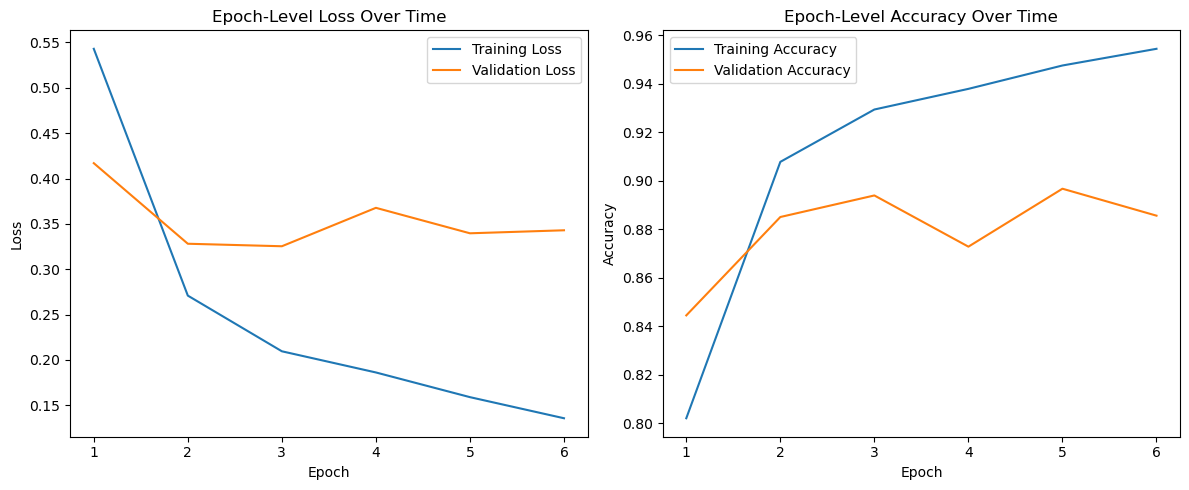

In [8]:
# ======================
# Plotting Epoch-Level Metrics
# ======================
epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch-Level Loss Over Time')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch-Level Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Optionally: Save the per-batch lists to disk (e.g., as numpy files or pickled objects)
# np.save('train_batches_losses.npy', np.array(train_batches_losses))
# np.save('train_batches_accs.npy', np.array(train_batches_accs))
# np.save('val_batches_losses.npy', np.array(val_batches_losses))
# np.save('val_batches_accs.npy', np.array(val_batches_accs))


#### Steps for Completition 
1) Save plots for the validation and epochs overtime
2) Make an argument for overfitting
3) I think if the current method does not work, we could change some of the learning parameters, but honestly, not sure how much we want to change at this point.
4) What's more important is just going thorugh talking about what worked and what didn't 